In [1]:
import pandas as pd

In [2]:
imdb = pd.read_csv('labeledTrainData.tsv', sep='\t',header=0) #CSV TAB SEPARATOR
imdb.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [4]:
# imdb['text_length'] = imdb['review'].apply(len)

In [5]:
imdb['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# g = sns.FacetGrid(imdb, col="sentiment", height=3, aspect=1)
# g = g.map(plt.hist, "text_length", bins=10)

In [8]:
from nltk.corpus import stopwords
import string

In [9]:
from bs4 import BeautifulSoup

In [10]:
imdb['review'] = imdb['review'].map(lambda x: BeautifulSoup(x).get_text())

In [11]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [12]:
# Check to make sure its working
imdb['review'].head(5).apply(text_process)

0    [stuff, going, moment, MJ, ive, started, liste...
1    [Classic, War, Worlds, Timothy, Hines, enterta...
2    [film, starts, manager, Nicholas, Bell, giving...
3    [must, assumed, praised, film, greatest, filme...
4    [Superbly, trashy, wondrously, unpretentious, ...
Name: review, dtype: object

## Count Vectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
X = imdb['review']
y = imdb['sentiment']

In [15]:
X = CountVectorizer().fit_transform(X)

In [16]:
# len(X)

## Train Test Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [19]:
from sklearn.naive_bayes import MultinomialNB #Naive Bayes cocok buat text categorization

In [20]:
nb = MultinomialNB().fit(X_train, y_train)

In [21]:
predictions = nb.predict(X_test)

In [22]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc

In [23]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[3323  473]
 [ 651 3053]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3796
           1       0.87      0.82      0.84      3704

   micro avg       0.85      0.85      0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500



In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [25]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()), 
    ('classifier', MultinomialNB()),
])

In [26]:
X = imdb['review']
y = imdb['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [27]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [28]:
predictions = pipeline.predict(X_test)

In [29]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[3327  469]
 [ 542 3162]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3796
           1       0.87      0.85      0.86      3704

   micro avg       0.87      0.87      0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



In [30]:
predictProba = pipeline.predict_proba(X_test)
predictProba[:10]

array([[0.31419915, 0.68580085],
       [0.53380055, 0.46619945],
       [0.34751111, 0.65248889],
       [0.50396118, 0.49603882],
       [0.26505151, 0.73494849],
       [0.89859481, 0.10140519],
       [0.42497598, 0.57502402],
       [0.39664901, 0.60335099],
       [0.38299625, 0.61700375],
       [0.79513599, 0.20486401]])

In [31]:
predictions = [0 if prob > 0.56 else 1 for prob in predictProba[:,0] ]

In [32]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[3084  712]
 [ 348 3356]]
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      3796
           1       0.82      0.91      0.86      3704

   micro avg       0.86      0.86      0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



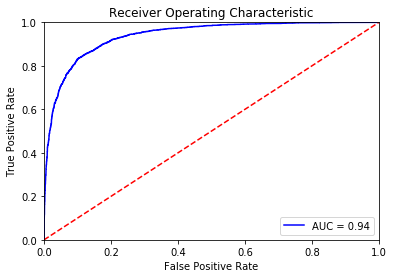

In [33]:
# calculate the fpr and tpr for all thresholds of the classification
preds = predictProba[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr,tpr)

# method 1 : plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr,'b',label= 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## TF IDF

In [34]:
imdb['review'].head(5).apply(text_process)

0    [stuff, going, moment, MJ, ive, started, liste...
1    [Classic, War, Worlds, Timothy, Hines, enterta...
2    [film, starts, manager, Nicholas, Bell, giving...
3    [must, assumed, praised, film, greatest, filme...
4    [Superbly, trashy, wondrously, unpretentious, ...
Name: review, dtype: object

In [35]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(imdb['review'])

In [36]:
bow_transformer.vocabulary_

{'stuff': 147077,
 'going': 98315,
 'moment': 117192,
 'MJ': 34500,
 'ive': 108417,
 'started': 145693,
 'listening': 112102,
 'music': 119196,
 'watching': 159698,
 'odd': 122343,
 'documentary': 85175,
 'watched': 159678,
 'Wiz': 59351,
 'Moonwalker': 37909,
 'Maybe': 36164,
 'want': 159217,
 'get': 97595,
 'certain': 74132,
 'insight': 106484,
 'guy': 99852,
 'thought': 151800,
 'really': 133252,
 'cool': 78839,
 'eighties': 87566,
 'maybe': 114864,
 'make': 113750,
 'mind': 116229,
 'whether': 160904,
 'guilty': 99692,
 'innocent': 106358,
 'part': 125787,
 'biography': 69573,
 'feature': 92676,
 'film': 93232,
 'remember': 134603,
 'see': 139187,
 'cinema': 75465,
 'originally': 123951,
 'released': 134408,
 'subtle': 147570,
 'messages': 115764,
 'MJs': 34503,
 'feeling': 92752,
 'towards': 153670,
 'press': 130214,
 'also': 63588,
 'obvious': 122225,
 'message': 115747,
 'drugs': 86460,
 'bad': 67244,
 'mkayVisually': 116991,
 'impressive': 105263,
 'course': 79474,
 'Michael': 

In [37]:
max(bow_transformer.vocabulary_.values())

164079

In [38]:
messages_bow = bow_transformer.transform(imdb['review'])

In [39]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (25000, 164080)
Amount of Non-Zero occurences:  2549965


In [40]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
review_tfidf = tfidf_transformer.transform(messages_bow)

In [41]:
from sklearn.naive_bayes import MultinomialNB #Naive Bayes cocok buat text categorization
review = MultinomialNB().fit(review_tfidf, imdb['sentiment'])

In [42]:
message4 = imdb['review'][3]
print(message4)
print(len(message4))

It must be assumed that those who praised this film (\the greatest filmed opera ever,\" didn't I read somewhere?) either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured. Either as a representation of Wagner's swan-song, or as a movie, this strikes me as an unmitigated disaster, with a leaden reading of the score matched to a tricksy, lugubrious realisation of the text.It's questionable that people with ideas as to what an opera (or, for that matter, a play, especially one by Shakespeare) is \"about\" should be allowed anywhere near a theatre or film studio; Syberberg, very fashionably, but without the smallest justification from Wagner's text, decided that Parsifal is \"about\" bisexual integration, so that the title character, in the latter stages, transmutes into a kind of beatnik babe, though one who continues to sing high tenor -- few if any of the actors in the film are the singers, and we get a double dose of Armin 

In [43]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 867)	1
  (0, 4635)	1
  (0, 4814)	1
  (0, 5477)	1
  (0, 5808)	1
  (0, 7430)	1
  (0, 7487)	1
  (0, 13760)	1
  (0, 14774)	1
  (0, 18780)	1
  (0, 21930)	1
  (0, 23803)	1
  (0, 24615)	1
  (0, 29719)	2
  (0, 29895)	1
  (0, 31213)	1
  (0, 37801)	1
  (0, 38511)	1
  (0, 42075)	2
  (0, 49768)	1
  (0, 51230)	1
  (0, 51378)	1
  (0, 53193)	2
  (0, 58171)	1
  (0, 58176)	2
  :	:
  (0, 147000)	1
  (0, 147045)	1
  (0, 148164)	1
  (0, 148713)	1
  (0, 150057)	1
  (0, 150147)	1
  (0, 150410)	1
  (0, 150412)	1
  (0, 150663)	2
  (0, 151386)	1
  (0, 151744)	2
  (0, 151843)	1
  (0, 152814)	1
  (0, 153962)	1
  (0, 154052)	1
  (0, 154401)	1
  (0, 154700)	1
  (0, 154887)	1
  (0, 156285)	1
  (0, 156455)	1
  (0, 156654)	1
  (0, 158787)	1
  (0, 158810)	1
  (0, 159838)	1
  (0, 161735)	1
(1, 164080)


In [44]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 161735)	0.03291703927566189
  (0, 159838)	0.025020608850729004
  (0, 158810)	0.05963848601275747
  (0, 158787)	0.04538451828160245
  (0, 156654)	0.09016428122481104
  (0, 156455)	0.06443903392668644
  (0, 156285)	0.07414004464491084
  (0, 154887)	0.0864512134111372
  (0, 154700)	0.09270190600615885
  (0, 154401)	0.10125741976002196
  (0, 154052)	0.10535156713287822
  (0, 153962)	0.10125741976002196
  (0, 152814)	0.040894684416723816
  (0, 151843)	0.05860194494731577
  (0, 151744)	0.061603622445421974
  (0, 151386)	0.02574727549638774
  (0, 150663)	0.11691049752343713
  (0, 150412)	0.10535156713287822
  (0, 150410)	0.06400929205721834
  (0, 150147)	0.08725943743531263
  (0, 150057)	0.10535156713287822
  (0, 148713)	0.09835257597052356
  (0, 148164)	0.055635718538140866
  (0, 147045)	0.052804578797353854
  (0, 147000)	0.05410545710536527
  :	:
  (0, 58176)	0.17820082583427713
  (0, 58171)	0.07735560248345957
  (0, 53193)	0.1854038120123177
  (0, 51378)	0.07084138008338343
  (0, 512

## Train Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(imdb['review'], imdb['sentiment'], test_size=0.3)

In [46]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [47]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x1a26ab3400>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [48]:
predictions = pipeline.predict(X_test)

In [69]:
predictions[10]

0

In [70]:
X_test.iloc[10]

'I guess I have still enough brain left to NOT find this movie funny. -Great comedians - but a very poor movie! The \\best\\" performance still did NINA HAGEN TRIVIA: Did you realize that it the \\"real world\\" scenes (in Hamburg) the cars are almost ONLY new BMWs ?? I guess I have still enough brain left to NOT find this movie funny. -Great comedians - but a very poor movie! The \\"best\\" performance still did NINA HAGEN TRIVIA: Did you realize that it the \\"real world\\" scenes (in Hamburg) the cars are almost ONLY new BMWs ??"'

In [50]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3751
           1       0.88      0.86      0.87      3749

   micro avg       0.87      0.87      0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



In [51]:
predictProba = pipeline.predict_proba(X_test)

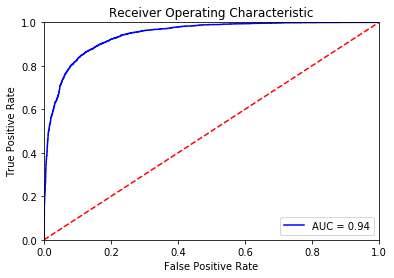

In [52]:
# calculate the fpr and tpr for all thresholds of the classification
preds = predictProba[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr,tpr)

# method 1 : plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr,'b',label= 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
test = pd.read_csv('testdata.tsv', sep='\t',header=0) #CSV TAB SEPARATOR
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [110]:
test['review'] = test['review'].map(lambda x: BeautifulSoup(x).get_text())

In [112]:
# test['review']

In [113]:
predictions = pipeline.predict(test['review'])

In [137]:
test['review'].iloc[1030]

"Savage Guns (video title) is a dirt cheap, bottom of the barrel spaghetti western in which the survivor of a massacre hunts the bandits who killed his brother and left him for dead, catching up with them in a town controlled by their crooked boss.Despite plenty of violence, this manages to be both dull and colorless with bad characterizations and almost no imagination or humor.Lead actor Robert Woods lives up to his name with a wooden and uncharismatic performance that fails to generate any warmth or sympathy whatsoever. In other words, the viewer never really roots for him despite the fact that he's the protagonist.The worst scene (in my opinion) is the annoying dance hall scene where a woman sings in a heavy and terribly unsexy German accent. It was the worst scene in Blazing Saddles and the worst one here!"

In [138]:
predictions[1030]

0

In [116]:
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [90]:
coba = pipeline.predict(pd.Series("good movie, very nice act and very well scripted. Recommended movie for you who wants to watch a really good movie"))
coba[0]

1

In [127]:
coba = pipeline.predict(pd.Series("great movie"))
coba[0]

1